In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
df = pd.read_csv("datatrain.csv")
df.head()

,Applied Loan Amount,Applied Loan Tenor,Gender,Age,Education Level,Monthly Housing/Rental,Monthly Income,Indicators
0,60000,24,1,22.301,Secondary,0.0,10245.0,0
1,100000,60,1,33.159,Form 3 or below,0.0,10000.0,0
2,50000,24,0,28.389,University,2000.0,9700.0,0
3,70000,36,1,35.573,Post Graduate,1200.0,23000.0,0
4,300000,60,0,30.849,University,11000.0,34000.0,0


In [ ]:
df = df.dropna()

In [ ]:
df = pd.get_dummies(df)
cols = df.columns.tolist()
cols.remove('Indicators')
cols.append('Indicators')
df = df[cols]
df.head() 

,Applied Loan Amount,Applied Loan Tenor,Gender,Age,Monthly Housing/Rental,Monthly Income,Education Level_Form 3 or below,Education Level_No Response,Education Level_Post Graduate,Education Level_Post Secondary,Education Level_Primary,Education Level_Secondary,Education Level_University,Indicators
0,60000,24,1,22.301,0.0,10245.0,0,0,0,0,0,1,0,0
1,100000,60,1,33.159,0.0,10000.0,1,0,0,0,0,0,0,0
2,50000,24,0,28.389,2000.0,9700.0,0,0,0,0,0,0,1,0
3,70000,36,1,35.573,1200.0,23000.0,0,0,1,0,0,0,0,0
4,300000,60,0,30.849,11000.0,34000.0,0,0,0,0,0,0,1,0


In [ ]:
# df = df.astype(np.float64)
# df["Final_Status (Y/N)"].astype(int)
df.dtypes

Applied Loan Amount                  int64
Applied Loan Tenor                   int64
Gender                               int64
Age                                float64
Monthly Housing/Rental             float64
Monthly Income                     float64
Education Level_Form 3 or below      uint8
Education Level_No Response          uint8
Education Level_Post Graduate        uint8
Education Level_Post Secondary       uint8
Education Level_Primary              uint8
Education Level_Secondary            uint8
Education Level_University           uint8
Indicators                           int64
dtype: object

In [ ]:
# df['Class_att'] = df['Class_att'].astype('category')
# encode_map = {
#     'Abnormal': 1,
#     'Normal': 0
# }

# df['Class_att'].replace(encode_map, inplace=True)

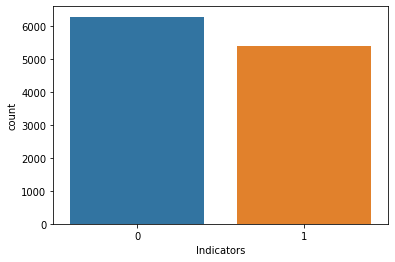

In [ ]:
sns.countplot(x = 'Indicators', data=df)

In [ ]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [ ]:
print(X.shape, y.shape)

(11669, 13) (11669,)


In [ ]:
np.any(np.isnan(y))

False

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
print(X_train.shape, X_test.shape)

(7818, 13) (3851, 13)


In [ ]:
EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [ ]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(torch.Tensor(y_train.values)))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1) # may need increase later

In [ ]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(13, 32) 
        self.layer_2 = nn.Linear(32, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
###############

cpu


In [ ]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=13, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()
e_loss = []
e_acc = []
timelist = []
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    start_time = time.time()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    total_time = time.time() - start_time
    timelist.append(total_time)
    e_loss.append(epoch_loss/len(train_loader)) # for plt
    e_acc.append(epoch_acc/len(train_loader)) # for plt
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Time: {total_time:.3f}')

Epoch 001: | Loss: 0.69313 | Acc: 55.033 | Time: 0.307
Epoch 002: | Loss: 0.66588 | Acc: 59.545 | Time: 0.302
Epoch 003: | Loss: 0.64844 | Acc: 62.813 | Time: 0.294
Epoch 004: | Loss: 0.63526 | Acc: 64.553 | Time: 0.306
Epoch 005: | Loss: 0.62786 | Acc: 65.780 | Time: 0.299
Epoch 006: | Loss: 0.62096 | Acc: 66.146 | Time: 0.334
Epoch 007: | Loss: 0.61904 | Acc: 66.423 | Time: 0.296
Epoch 008: | Loss: 0.61224 | Acc: 67.016 | Time: 0.308
Epoch 009: | Loss: 0.60989 | Acc: 67.407 | Time: 0.295
Epoch 010: | Loss: 0.61036 | Acc: 67.593 | Time: 0.294
Epoch 011: | Loss: 0.60616 | Acc: 67.813 | Time: 0.298
Epoch 012: | Loss: 0.60226 | Acc: 68.260 | Time: 0.305
Epoch 013: | Loss: 0.60279 | Acc: 68.504 | Time: 0.292
Epoch 014: | Loss: 0.60025 | Acc: 68.504 | Time: 0.302
Epoch 015: | Loss: 0.59891 | Acc: 68.870 | Time: 0.297
Epoch 016: | Loss: 0.59527 | Acc: 68.878 | Time: 0.305
Epoch 017: | Loss: 0.59747 | Acc: 68.943 | Time: 0.296
Epoch 018: | Loss: 0.59352 | Acc: 69.171 | Time: 0.317
Epoch 019:

In [ ]:
# n_list = np.arange(1, 501).tolist()
# n_list = pd.Series(n_list)
# time_list = pd.Series(timelist)

In [ ]:
import statistics
statistics.mean(timelist)

0.2944057905673981

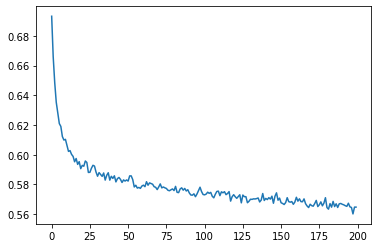

In [ ]:
plt.plot(e_loss)

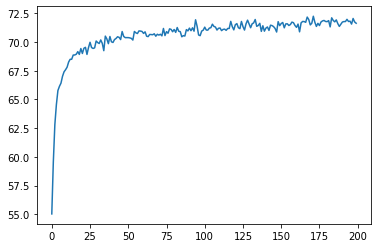

In [ ]:
plt.plot(e_acc)

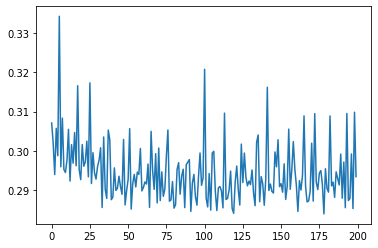

In [ ]:
plt.plot(timelist)

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
confusion_matrix(y_test, y_pred_list)

array([[1616,  419],
       [ 695, 1121]])

In [ ]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      2035
           1       0.73      0.62      0.67      1816

    accuracy                           0.71      3851
   macro avg       0.71      0.71      0.71      3851
weighted avg       0.71      0.71      0.71      3851

